In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('Crop_recommendation.csv')
df.head()

,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,label,Unnamed: 8,Unnamed: 9
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,NaN,NaN
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,NaN,NaN
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,NaN,NaN
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,NaN,NaN
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,NaN,NaN


In [3]:
df.drop(['Unnamed: 8','Unnamed: 9'],axis=1,inplace=True)

## Adding new columns

In [4]:
def enhance_crop_dataset(df):
    """
    Add meaningful features to improve crop classification accuracy
    """
    
    # Create a copy for enhancement
    enhanced_df = df.copy()
    
    # 1. SOIL NUTRIENT FEATURES
    # -------------------------
    
    # Total NPK (Nitrogen + Phosphorus + Potassium)
    enhanced_df['total_npk'] = enhanced_df['Nitrogen'] + enhanced_df['phosphorus'] + enhanced_df['potassium']
    
    # NPK Ratios (important for crop nutrition)
    enhanced_df['n_p_ratio'] = enhanced_df['Nitrogen'] / (enhanced_df['phosphorus'] + 1)  # +1 to avoid division by zero
    enhanced_df['n_k_ratio'] = enhanced_df['Nitrogen'] / (enhanced_df['potassium'] + 1)
    enhanced_df['p_k_ratio'] = enhanced_df['phosphorus'] / (enhanced_df['potassium'] + 1)
    
    # Nutrient balance index
    enhanced_df['nutrient_balance'] = np.abs(enhanced_df['Nitrogen'] - enhanced_df['phosphorus']) + \
                                    np.abs(enhanced_df['phosphorus'] - enhanced_df['potassium']) + \
                                    np.abs(enhanced_df['Nitrogen'] - enhanced_df['potassium'])
    
    # Soil fertility index (weighted combination)
    enhanced_df['soil_fertility_index'] = (enhanced_df['Nitrogen'] * 0.4 + 
                                         enhanced_df['phosphorus'] * 0.3 + 
                                         enhanced_df['potassium'] * 0.3)
    
    # 2. CLIMATE & ENVIRONMENTAL FEATURES
    # -----------------------------------
    
    # Temperature categories
    enhanced_df['temp_category'] = pd.cut(enhanced_df['temperature'], 
                                        bins=[0, 15, 25, 35, 50], 
                                        labels=['Cool', 'Moderate', 'Warm', 'Hot'])
    
    # Humidity categories
    enhanced_df['humidity_category'] = pd.cut(enhanced_df['humidity'], 
                                            bins=[0, 40, 70, 90, 100], 
                                            labels=['Low', 'Moderate', 'High', 'Very_High'])
    
    # Rainfall categories
    enhanced_df['rainfall_category'] = pd.cut(enhanced_df['rainfall'], 
                                            bins=[0, 50, 100, 200, 300], 
                                            labels=['Low', 'Moderate', 'High', 'Very_High'])
    
    # Growing Degree Days (GDD) - important for crop development
    base_temp = 10  # Base temperature for most crops
    enhanced_df['growing_degree_days'] = np.maximum(enhanced_df['temperature'] - base_temp, 0)
    
    # Heat Index (combination of temperature and humidity)
    enhanced_df['heat_index'] = enhanced_df['temperature'] + (enhanced_df['humidity'] / 100) * enhanced_df['temperature']
    
    # Aridity Index (rainfall vs temperature relationship)
    enhanced_df['aridity_index'] = enhanced_df['rainfall'] / (enhanced_df['temperature'] + 1)
    
    # 3. SOIL pH FEATURES
    # -------------------
    
    # pH categories (important for nutrient availability)
    enhanced_df['ph_category'] = pd.cut(enhanced_df['ph'], 
                                      bins=[0, 5.5, 6.5, 7.5, 10], 
                                      labels=['Acidic', 'Slightly_Acidic', 'Neutral', 'Alkaline'])
    
    # pH suitability for nutrient uptake
    enhanced_df['ph_nutrient_availability'] = np.where(
        (enhanced_df['ph'] >= 6.0) & (enhanced_df['ph'] <= 7.5), 1, 0
    )
    
    # Distance from optimal pH (6.5-7.0 is generally optimal)
    enhanced_df['ph_optimality'] = 1 - np.abs(enhanced_df['ph'] - 6.75) / 6.75
    
    # 4. INTERACTION FEATURES
    # -----------------------
    
    # Temperature-Humidity interaction
    enhanced_df['temp_humidity_interaction'] = enhanced_df['temperature'] * enhanced_df['humidity'] / 100
    
    # Rainfall-Temperature balance
    enhanced_df['water_temp_balance'] = enhanced_df['rainfall'] / (enhanced_df['temperature'] + 1)
    
    # Nutrient-Climate interaction
    enhanced_df['nutrient_climate_index'] = (enhanced_df['total_npk'] / 100) * \
                                          (enhanced_df['temperature'] / 30) * \
                                          (enhanced_df['rainfall'] / 150)
    
    # 5. SEASONAL/GROWTH CONDITIONS
    # -----------------------------
    
    # Stress indicators
    enhanced_df['heat_stress'] = np.where(enhanced_df['temperature'] > 35, 1, 0)
    enhanced_df['drought_stress'] = np.where(enhanced_df['rainfall'] < 50, 1, 0)
    enhanced_df['waterlogging_risk'] = np.where(enhanced_df['rainfall'] > 250, 1, 0)
    
    # Optimal growing conditions indicator
    enhanced_df['optimal_conditions'] = np.where(
        (enhanced_df['temperature'] >= 20) & (enhanced_df['temperature'] <= 30) &
        (enhanced_df['humidity'] >= 60) & (enhanced_df['humidity'] <= 80) &
        (enhanced_df['rainfall'] >= 75) & (enhanced_df['rainfall'] <= 200) &
        (enhanced_df['ph'] >= 6.0) & (enhanced_df['ph'] <= 7.5), 1, 0
    )
    
    # 6. CROP-SPECIFIC DERIVED FEATURES
    # ----------------------------------
    
    # Water requirement index
    enhanced_df['water_requirement_index'] = enhanced_df['rainfall'] * enhanced_df['humidity'] / 1000
    
    # Soil richness score
    enhanced_df['soil_richness'] = (enhanced_df['Nitrogen'] / 140) * 0.4 + \
                                 (enhanced_df['phosphorus'] / 145) * 0.3 + \
                                 (enhanced_df['potassium'] / 205) * 0.3
    
    # Climate suitability score
    enhanced_df['climate_suitability'] = (1 - np.abs(enhanced_df['temperature'] - 25) / 25) * 0.4 + \
                                        (enhanced_df['humidity'] / 100) * 0.3 + \
                                        (np.minimum(enhanced_df['rainfall'], 200) / 200) * 0.3
    
    # 7. ENCODE CATEGORICAL VARIABLES
    # -------------------------------
    
    # Create encoded versions of categorical variables for ML models
    le_temp = LabelEncoder()
    le_humidity = LabelEncoder()
    le_rainfall = LabelEncoder()
    le_ph = LabelEncoder()
    
    enhanced_df['temp_category_encoded'] = le_temp.fit_transform(enhanced_df['temp_category'].astype(str))
    enhanced_df['humidity_category_encoded'] = le_humidity.fit_transform(enhanced_df['humidity_category'].astype(str))
    enhanced_df['rainfall_category_encoded'] = le_rainfall.fit_transform(enhanced_df['rainfall_category'].astype(str))
    enhanced_df['ph_category_encoded'] = le_ph.fit_transform(enhanced_df['ph_category'].astype(str))
    
    return enhanced_df

# Enhance the dataset
enhanced_df = enhance_crop_dataset(df)

print(f"\nEnhanced Dataset Shape: {enhanced_df.shape}")
print(f"New Features Added: {enhanced_df.shape[1] - df.shape[1]}")


Enhanced Dataset Shape: (2200, 37)
New Features Added: 29


In [5]:
enhanced_df.head()

,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,label,total_npk,n_p_ratio,...,drought_stress,waterlogging_risk,optimal_conditions,water_requirement_index,soil_richness,climate_suitability,temp_category_encoded,humidity_category_encoded,rainfall_category_encoded,ph_category_encoded
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,175,2.093023,...,0,0,0,16.641271,0.406966,0.880084,2,0,3,2
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,184,1.440678,...,0,0,0,18.204892,0.422857,0.889286,2,0,3,2
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,159,1.071429,...,0,1,0,21.729738,0.349612,0.915034,2,0,3,1
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,149,2.055556,...,0,0,0,19.467583,0.342379,0.916618,3,0,3,2
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,162,1.813953,...,0,1,0,21.439015,0.371217,0.866897,2,0,3,1


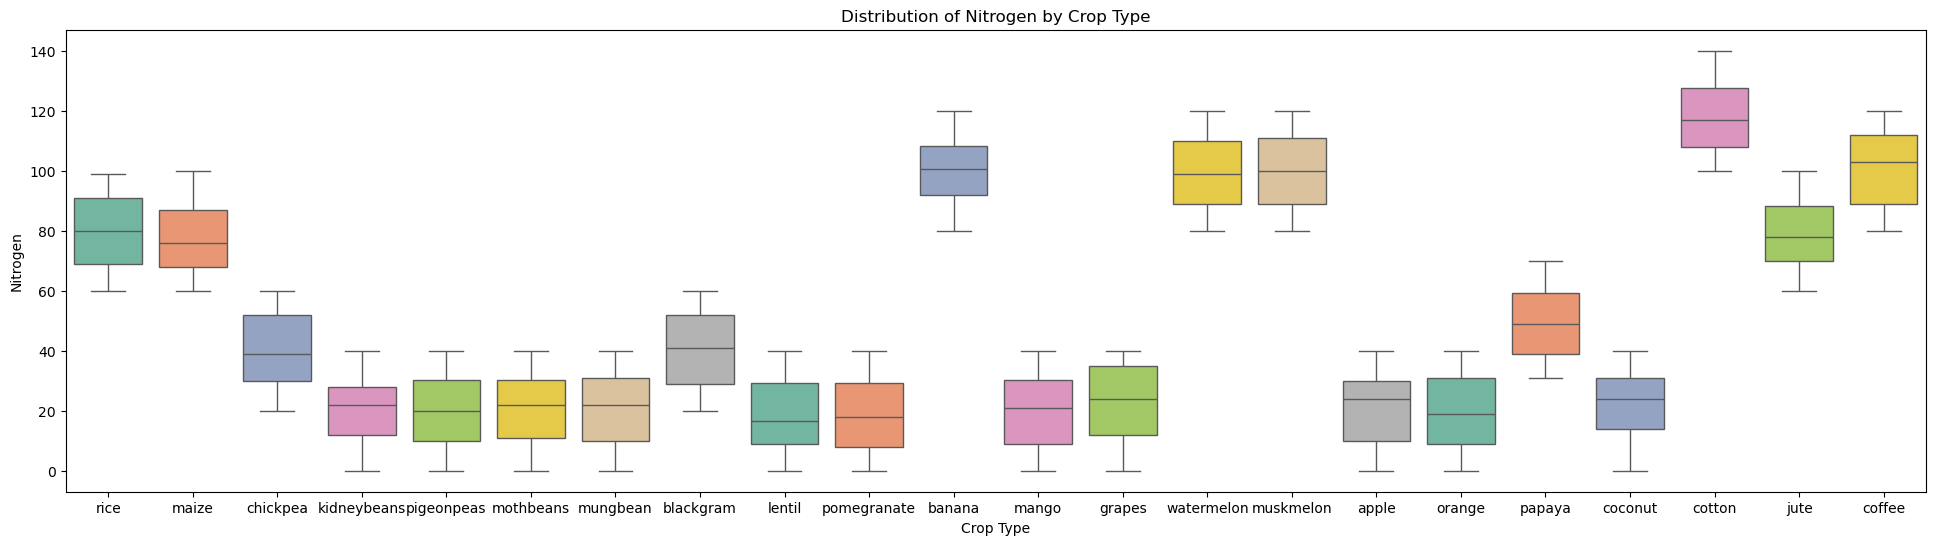

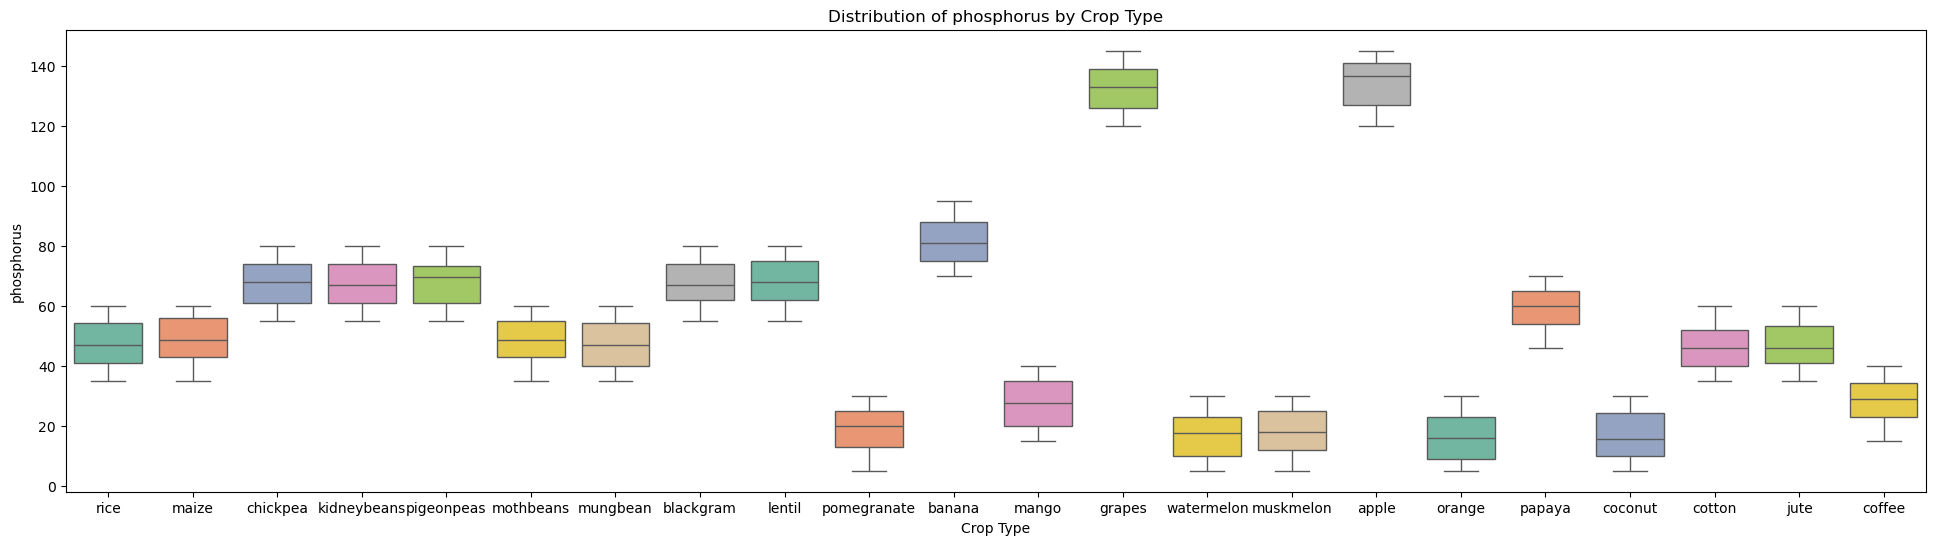

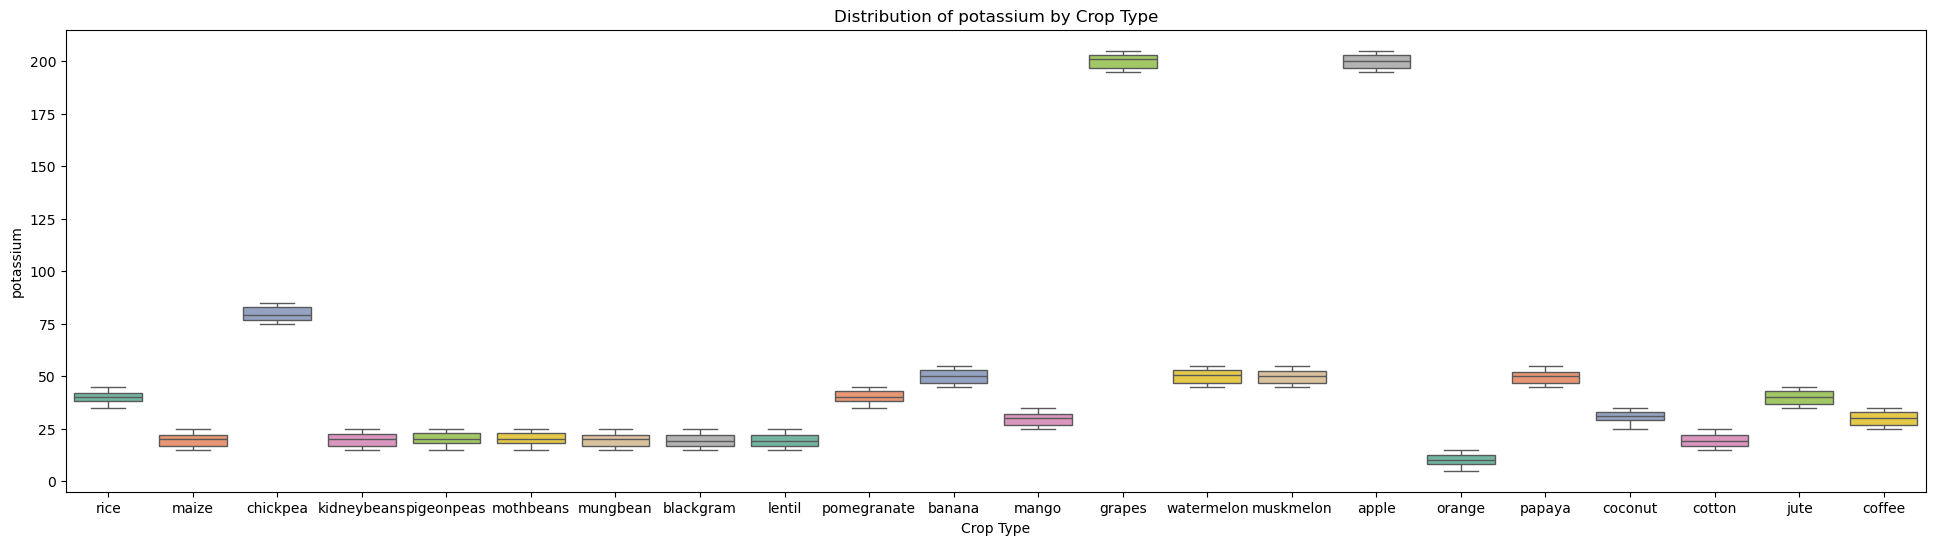

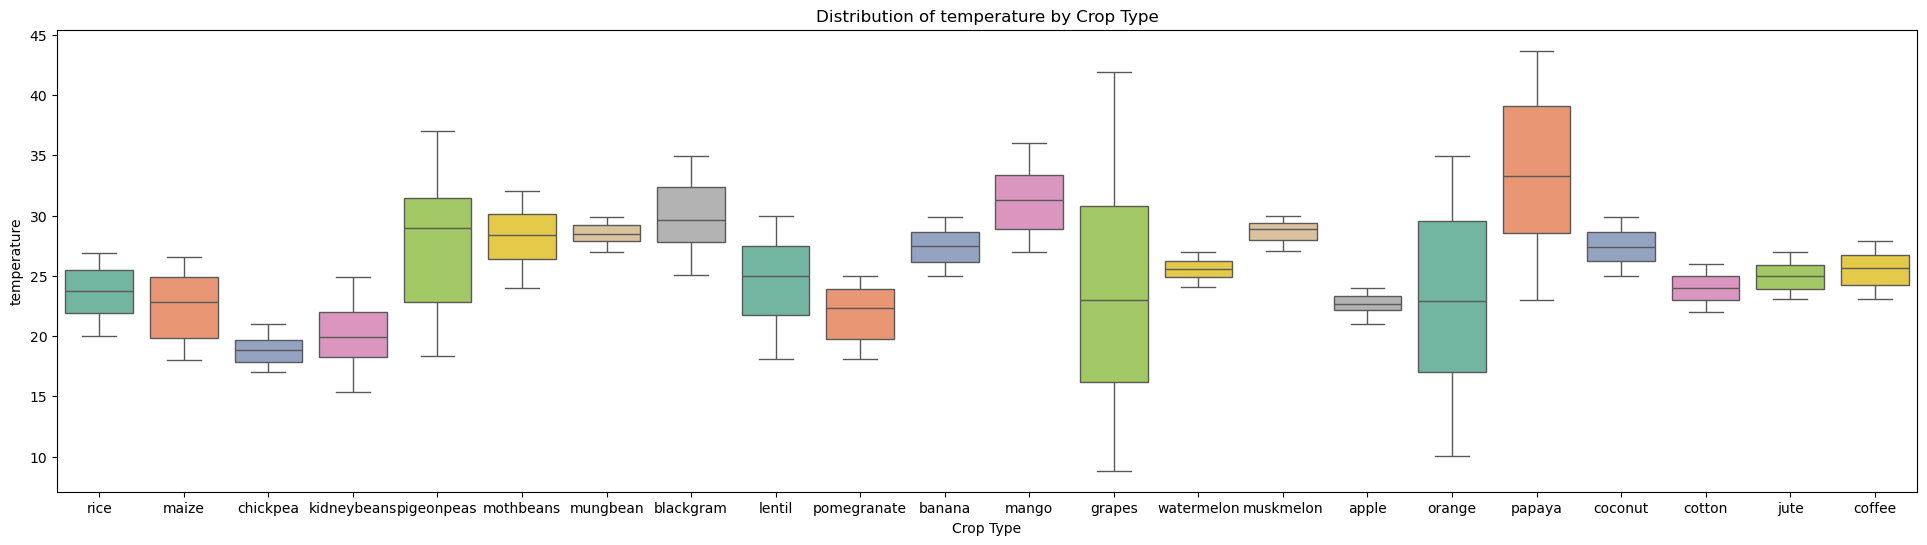

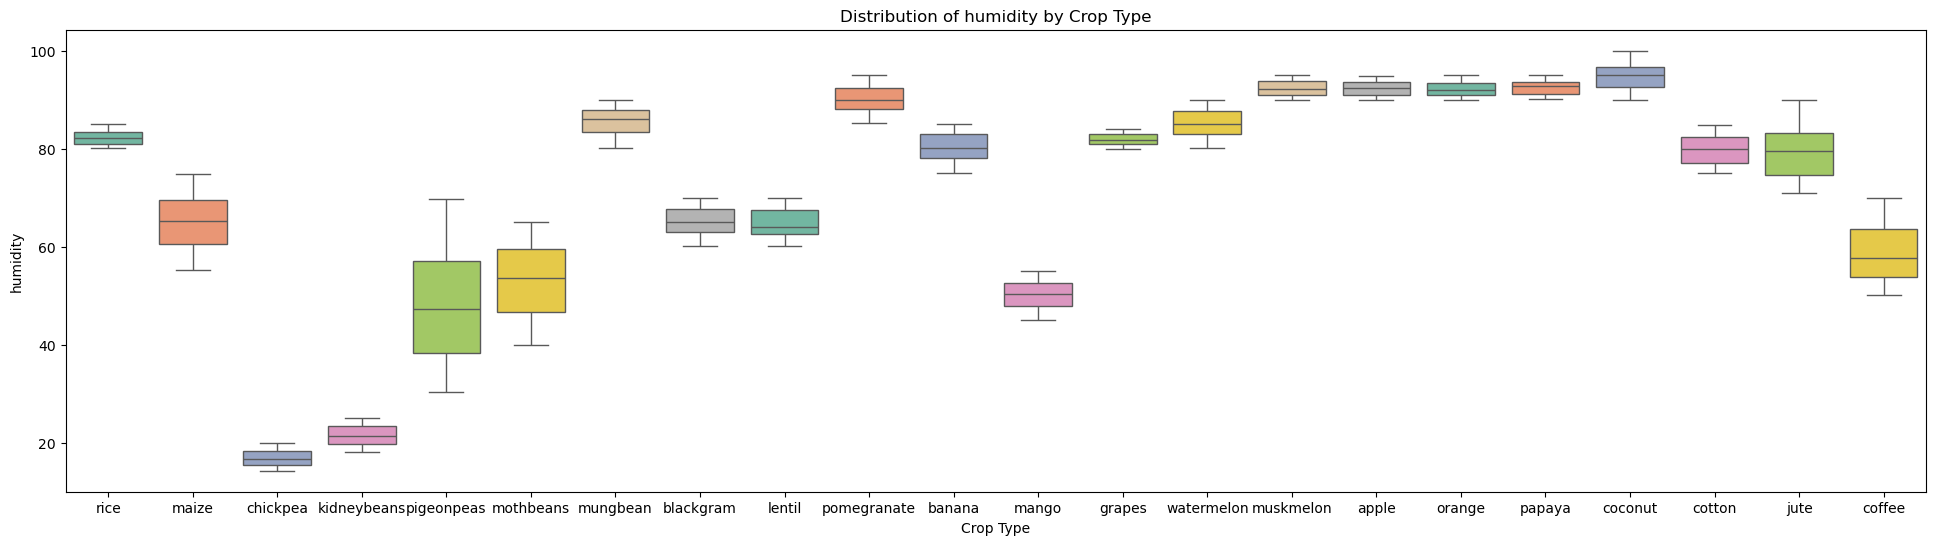

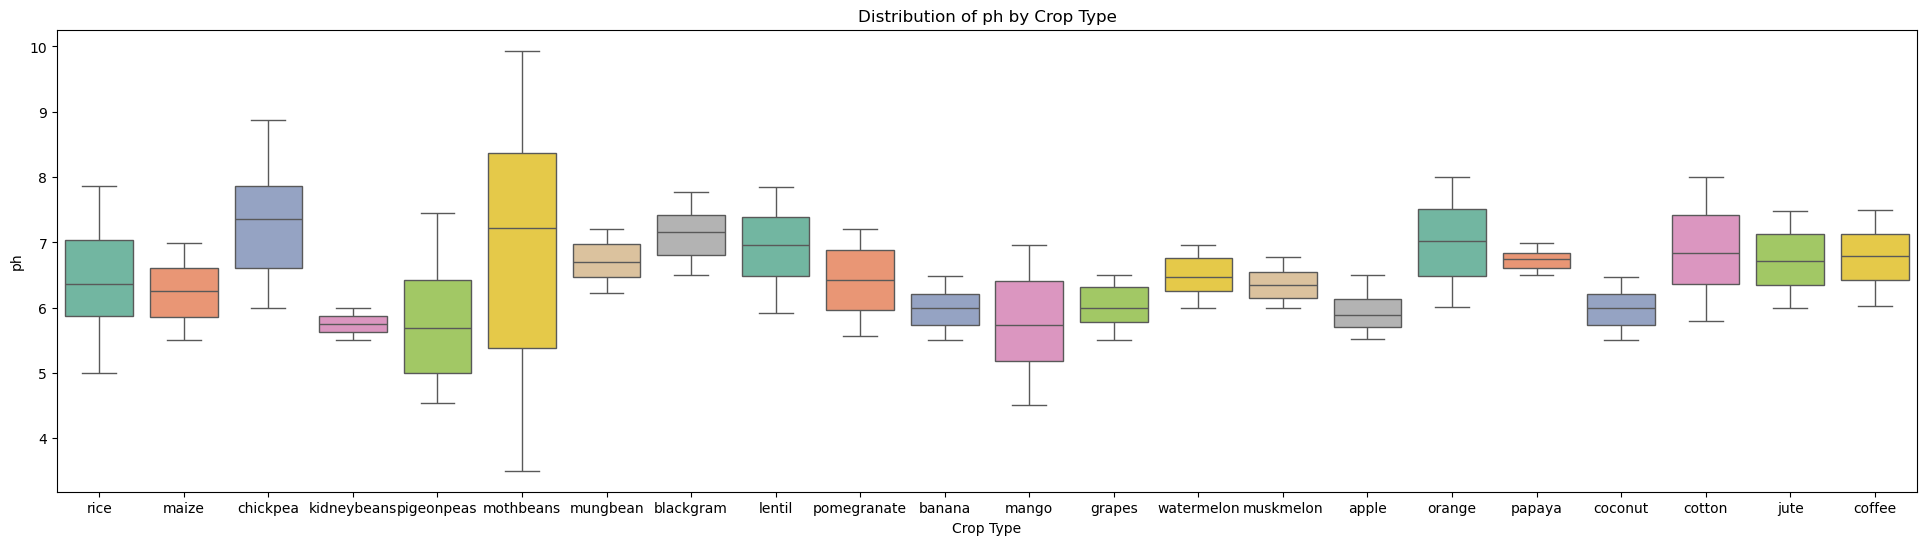

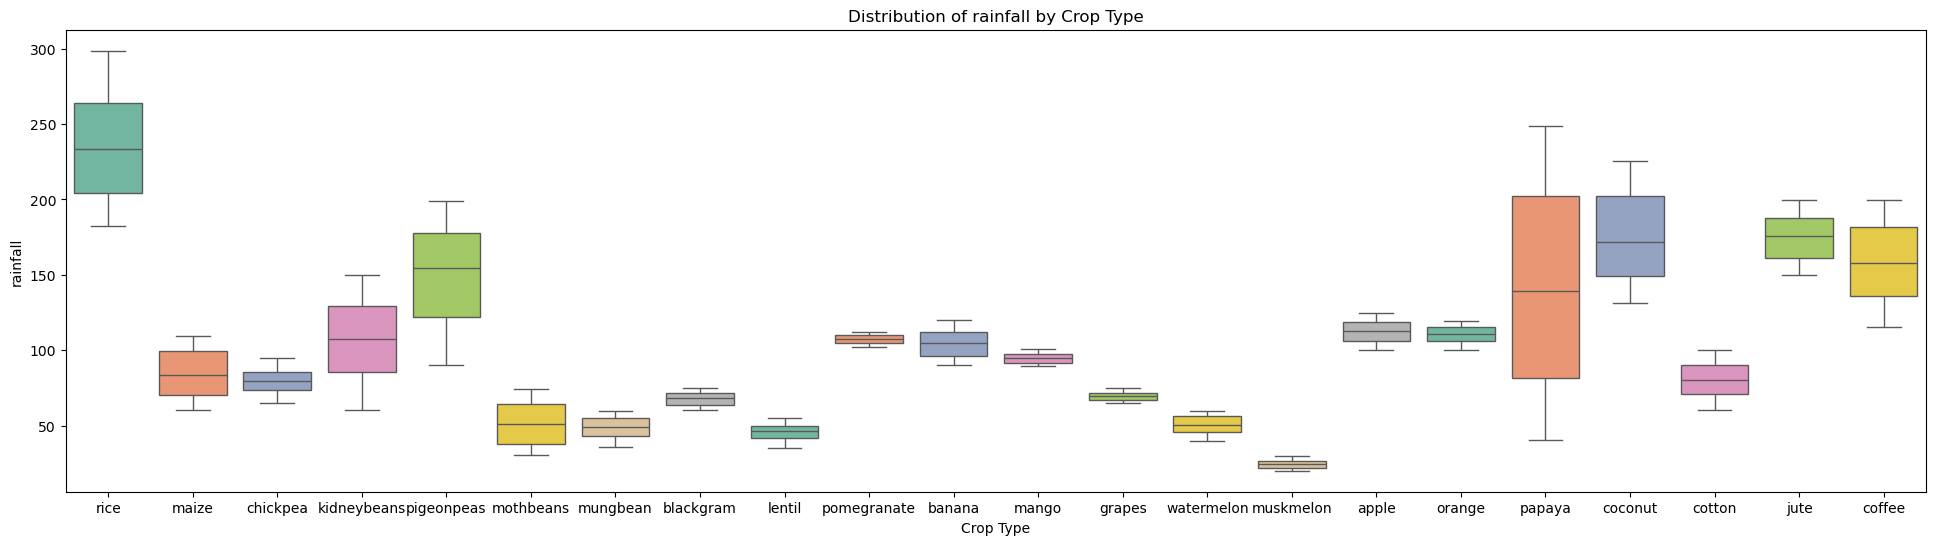

In [11]:
features=['Nitrogen', 'phosphorus', 'potassium', 'temperature', 'humidity', 'ph', 'rainfall']

for feature in features:
    plt.figure(figsize=(24, 6))
    sns.boxplot(x='label', y=feature, data=enhanced_df, palette='Set2')
    plt.title(f'Distribution of {feature} by Crop Type')
    plt.xlabel('Crop Type')
    plt.ylabel(feature)
    plt.show()


In [26]:
# for crop in enhanced_df['label'].unique():
#     print(f"The mean of all the features for {crop} is:")
#     for feature in features:
#         mean_value = enhanced_df.groupby(enhanced_df['label'] == crop)[feature].mean()
#         print(f"{feature}: {mean_value}")
    
group_means = enhanced_df.groupby('label')[features].mean()

for crop in enhanced_df['label'].unique():
    print(f"The mean of all the features for {crop} is:")
    for feature in features:
        print(f"{feature}: {group_means.loc[crop, feature]}")
    print()


The mean of all the features for rice is:
Nitrogen: 79.89
phosphorus: 47.58
potassium: 39.87
temperature: 23.6893322105
humidity: 82.2728215389
ph: 6.425470922140001
rainfall: 236.18111359399998

The mean of all the features for maize is:
Nitrogen: 77.76
phosphorus: 48.44
potassium: 19.79
temperature: 22.3892039102
humidity: 65.0922494467
ph: 6.2451897224
rainfall: 84.766987663

The mean of all the features for chickpea is:
Nitrogen: 40.09
phosphorus: 67.79
potassium: 79.92
temperature: 18.8728467519
humidity: 16.8604394237
ph: 7.33695662374
rainfall: 80.0589772605

The mean of all the features for kidneybeans is:
Nitrogen: 20.75
phosphorus: 67.54
potassium: 20.05
temperature: 20.1150846851
humidity: 21.6053567295
ph: 5.749410585870001
rainfall: 105.91977754210001

The mean of all the features for pigeonpeas is:
Nitrogen: 20.73
phosphorus: 67.73
potassium: 20.29
temperature: 27.7417622259
humidity: 48.0616330847
ph: 5.794174879790001
rainfall: 149.4575638135

The mean of all the featur

In [28]:
enhanced_df.groupby('label')[features].mean()


,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall
label,,,,,,,
apple,20.80,134.22,199.89,22.630942,92.333383,5.929663,112.654779
banana,100.23,82.01,50.05,27.376798,80.358123,5.983893,104.626980
blackgram,40.02,67.47,19.24,29.973340,65.118426,7.133952,67.884151
chickpea,40.09,67.79,79.92,18.872847,16.860439,7.336957,80.058977
coconut,21.98,16.93,30.59,27.409892,94.844272,5.976562,175.686646
coffee,101.20,28.74,29.94,25.540477,58.869846,6.790308,158.066295
cotton,117.77,46.24,19.56,23.988958,79.843474,6.912675,80.398043
grapes,23.18,132.53,200.11,23.849575,81.875228,6.025937,69.611829
jute,78.40,46.86,39.99,24.958376,79.639864,6.732778,174.792798
